In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage.filters as flt
import matplotlib as mpl
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
#from lecturesupport import plotsupport as ps
import pandas as pd
from sklearn.datasets import make_blobs
import scipy.stats as stats
import astropy.io.fits as fits
import skimage.io as io
%matplotlib inline


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'png')
#plt.style.use('seaborn')
mpl.rcParams['figure.dpi'] = 150

# Load the data

In [ ]:
img=io.imread('../data/spots/mixture12_00001.png')
orig= fits.getdata('../data/spots/mixture12_00001.fits')

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,6))
r=600
c=600
w=256
mask=(img[:,:,1]==0)

ax[0].imshow(orig[r:(r+w),c:(c+w)],vmin=0, vmax=4000,cmap='gray'), ax[0].set_title('Original projection')
ax[1].imshow(img[r:(r+w),c:(c+w)]), ax[1].set_title('Mark up')
ax[2].imshow(mask[r:(r+w),c:(c+w)],cmap='gray'),ax[2].set_title('Mask');
plt.tight_layout()
plt.savefig('../lecture/figures/markedspots.svg')
plt.savefig('../lecture/figures/markedspots.pdf')

In [ ]:
h=plt.hist(orig.ravel(),bins=256);

In [ ]:
hspots,axspots=np.histogram(orig[mask].ravel(),bins=256)
hall,axall=np.histogram(orig.ravel(),bins=256)

In [ ]:
plt.plot(axspots[:-1],hspots,label='Spots')
plt.plot(axall[:-1],hall,label='All data')
plt.legend();


In [ ]:
selem = np.ones([7,7])
forig=orig.astype('float32')
mimg = flt.median(forig,selem=selem)

In [ ]:
d=np.abs(forig-mimg)
plt.imshow(d,vmin=0,vmax=500,cmap='gray')

In [ ]:
hd,axd=np.histogram(d[mask].ravel(),bins=256)

In [ ]:
plt.plot(axd[:-1],hd,label='Spots')
plt.plot(axall[:-1],hall,label='All data')
plt.legend();

In [ ]:
h,x,y,u=plt.hist2d(d[:512,:512].ravel(),orig[:512,:512].ravel(), bins=100);

In [ ]:
plt.imshow(np.log(h[::-1]+1),extent=[x.min(),x.max(),y.min(),y.max()])
plt.xlabel('Input image')
plt.ylabel('Median filtered image')
plt.title('Log bivariate histogram')


## knn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
k_class = KNeighborsClassifier(1)
trainorig = forig[:1000,:].ravel()
traind    = d[:1000,:].ravel()
trainmask = mask[:1000,:].ravel()

test_pts = pd.DataFrame(trainorig, columns=['orig'])
test_pts['d']=traind
test_pts['mask']=trainmask
test_pts.sample(5)

k_class = KNeighborsClassifier(1)
k_class.fit(test_pts[['orig', 'd']], test_pts['mask']) 


In [ ]:
xx, yy = np.meshgrid(np.linspace(test_pts.orig.min(), test_pts.orig.max(), 100),np.linspace(test_pts.d.min(), test_pts.d.max(), 100),indexing='ij');
grid_pts = pd.DataFrame(dict(x=xx.ravel(), y=yy.ravel()))
grid_pts['predicted_id'] = k_class.predict(grid_pts[['x', 'y']])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax2.scatter(grid_pts.x, grid_pts.y, c=grid_pts.predicted_id, cmap='viridis'); ax2.set_title('Testing Points');

In [ ]:
testorig = forig[1000:,:].ravel()
testd    = d[1000:,:].ravel()
testmask = mask[1000:,:].ravel()

test_pts = pd.DataFrame(testorig, columns=['orig'])
test_pts['d']=testd
test_pts['mask']=testmask

In [ ]:
pred = k_class.predict(test_pts[['orig', 'd']])
pimg = pred.reshape(d[1000:,:].shape)

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(forig[1000:,:],vmin=0,vmax=4000)
ax[1].imshow(pimg)
ax[2].imshow(mask[1000:,:])

In [ ]:
def splitTiles(img,size=[64,64]) :
    dims = img.shape
    nTiles = [dims[0]//(size[0]), dims[0]//(size[0])]
    
    tiles = []
    img=img/65535.0
    for x in range(nTiles[0]) :
        for y in range(nTiles[1]) :
            tiles.append(img[x*size[0]:(x+1)*size[0],y*size[1]:(y+1)*size[1]].astype('float32').tolist())
            
    return tiles
    

In [ ]:
tileSize=64
origTiles = splitTiles(orig,size=[tileSize,tileSize]);
maskTiles = splitTiles(mask,size=[tileSize,tileSize]);

In [ ]:
len(origTiles)

In [ ]:
(orig.shape[0]/64)**2

In [ ]:
fig,ax = plt.subplots(2,5,figsize=(15,8))
ax=ax.ravel()
for idx,item in enumerate(np.random.randint(len(origTiles), size=5)) :
    ax[idx].imshow(origTiles[item],vmin=200,vmax=4000)
    ax[idx+5].imshow(maskTiles[item])

## Prepare the streaming class

In [ ]:
print(len(origTiles),len(origTiles[1]),len(origTiles[2]))

In [ ]:
tOrig= tf.constant(origTiles)
tMask= tf.constant(maskTiles)


In [ ]:
dsOrig = tf.data.Dataset.from_tensor_slices(tOrig)
dsMask = tf.data.Dataset.from_tensor_slices(tMask)

In [ ]:
dataset

In [ ]:
# Outlining the model/architecture of our CNN
# CONV -> MAXPOOL -> CONV -> MAXPOOL -> FLATTEN -> DENSE
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(tileSize, tileSize, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    # (2,2) is the default pool size so we could have just used MaxPooling2D() with no explicit arguments
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10) # You can apply softmax activation here, see below for comentary
])
    

In [ ]:
# A brief summary of the model and parameters
model.summary(line_length = 75)

## Prepare the model

In [ ]:
def create_model_myunet(depth, start_f, output_channels, encoder_kernel_size):

    # Encoder
    model = tf.keras.Sequential()

    for i in range(0, depth):

        if i == 0:
            print("Specifying an input shape")
            input_shape = [config.img_h, config.img_w, 3]
        else:
            input_shape = [None]

        model.add(tf.keras.layers.Conv2D(filters=2**(start_f+i), 
                                         kernel_size=(encoder_kernel_size, encoder_kernel_size),
                                         strides=(1, 1),
                                         padding='same',
                                         input_shape=input_shape,
                                         name = "enc_conv2d_" + str(i)))
        model.add(tf.keras.layers.ReLU(name = "enc_relu_" + str(i)))
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name="enc_maxpool2d_" + str(i)))

    # Decoder
    initializer = tf.random_normal_initializer(0., 0.02)

    for i in range(depth, 1, -1):

        model.add(
        tf.keras.layers.Conv2DTranspose(2**(start_f+i),
                                        encoder_kernel_size,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False)
        )

        model.add(tf.keras.layers.BatchNormalization())

        model.add(tf.keras.layers.ReLU(name="dec_relu_"+str(i)))

        model.add(tf.keras.layers.Concatenate()([  # Sequential api
            model.get_layer(name="dec_relu_"+str(i)).output,  
            model.get_layer(name="enc_relu_"+str(i-1)).output
        ] ))
        pass

    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

    model.add(last)

    return model

In [ ]:
def unet(pretrained_weights = None,input_size = (64,64,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

![](https://github.com/zhixuhao/unet/blob/master/img/u-net-architecture.png "test")

[Good start](https://github.com/zhixuhao/unet)

# From QBI lecture

# U-Net

The last approach we will briefly cover is the idea of [U-Net](https://arxiv.org/abs/1505.04597) a landmark paper from 2015 that dominates MICCAI submissions and contest winners today. A nice overview of the techniques is presented by [Vladimir Iglovikov](https://youtu.be/g6oIQ5MXBE4) a winner of a recent Kaggle competition on masking images of cars [slides](http://slides.com/vladimiriglovikov/kaggle-deep-learning-to-create-a-model-for-binary-segmentation-of-car-images)

![U-Net Diagram](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [208]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
base_depth = 48
in_img = Input((None, None, 1), name='Image_Input')
lay_1 = Conv2D(base_depth, kernel_size=(3, 3), padding='same',activation='relu')(in_img)
lay_2 = Conv2D(base_depth, kernel_size=(3, 3), padding='same',activation='relu')(lay_1)
lay_3 = MaxPooling2D(pool_size=(2, 2))(lay_2)
lay_4 = Conv2D(base_depth*2, kernel_size=(3, 3), padding='same',activation='relu')(lay_3)
lay_5 = Conv2D(base_depth*2, kernel_size=(3, 3), padding='same',activation='relu')(lay_4)
lay_6 = MaxPooling2D(pool_size=(2, 2))(lay_5)
lay_7 = Conv2D(base_depth*4, kernel_size=(3, 3), padding='same',activation='relu')(lay_6)
lay_8 = Conv2D(base_depth*4, kernel_size=(3, 3), padding='same',activation='relu')(lay_7)
lay_9 = UpSampling2D((2, 2))(lay_8)
lay_10 = concatenate([lay_5, lay_9])
lay_11 = Conv2D(base_depth*2, kernel_size=(3, 3), padding='same',activation='relu')(lay_10)
lay_12 = Conv2D(base_depth*2, kernel_size=(3, 3), padding='same',activation='relu')(lay_11)
lay_13 = UpSampling2D((2, 2))(lay_12)
lay_14 = concatenate([lay_2, lay_13])
lay_15 = Conv2D(base_depth, kernel_size=(3, 3), padding='same',activation='relu')(lay_14)
lay_16 = Conv2D(base_depth, kernel_size=(3, 3), padding='same',activation='relu')(lay_15)
lay_17 = Conv2D(1, kernel_size=(1, 1), padding='same',
                activation='relu')(lay_16)
t_unet = Model(inputs=[in_img], outputs=[lay_17], name='SmallUNET')

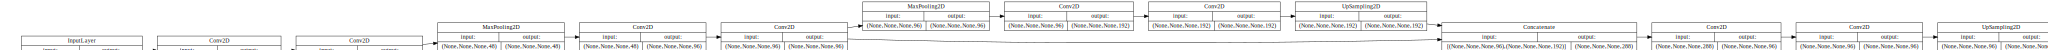

In [209]:
dot_mod = model_to_dot(t_unet, show_shapes=True, show_layer_names=False)
dot_mod.set_rankdir('LR')
SVG(dot_mod.create_svg())

In [210]:
t_unet.summary()

Model: "SmallUNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, None, None, 4 480         Image_Input[0][0]                
__________________________________________________________________________________________________
conv2d_123 (Conv2D)             (None, None, None, 4 20784       conv2d_122[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_23 (MaxPooling2D) (None, None, None, 4 0           conv2d_123[0][0]                 
__________________________________________________________________________________________

# New training data
- Smaller training image (to save time)

Training (128, 1200) (128, 1200)
Validation Data (1548, 1200) (1548, 1200)


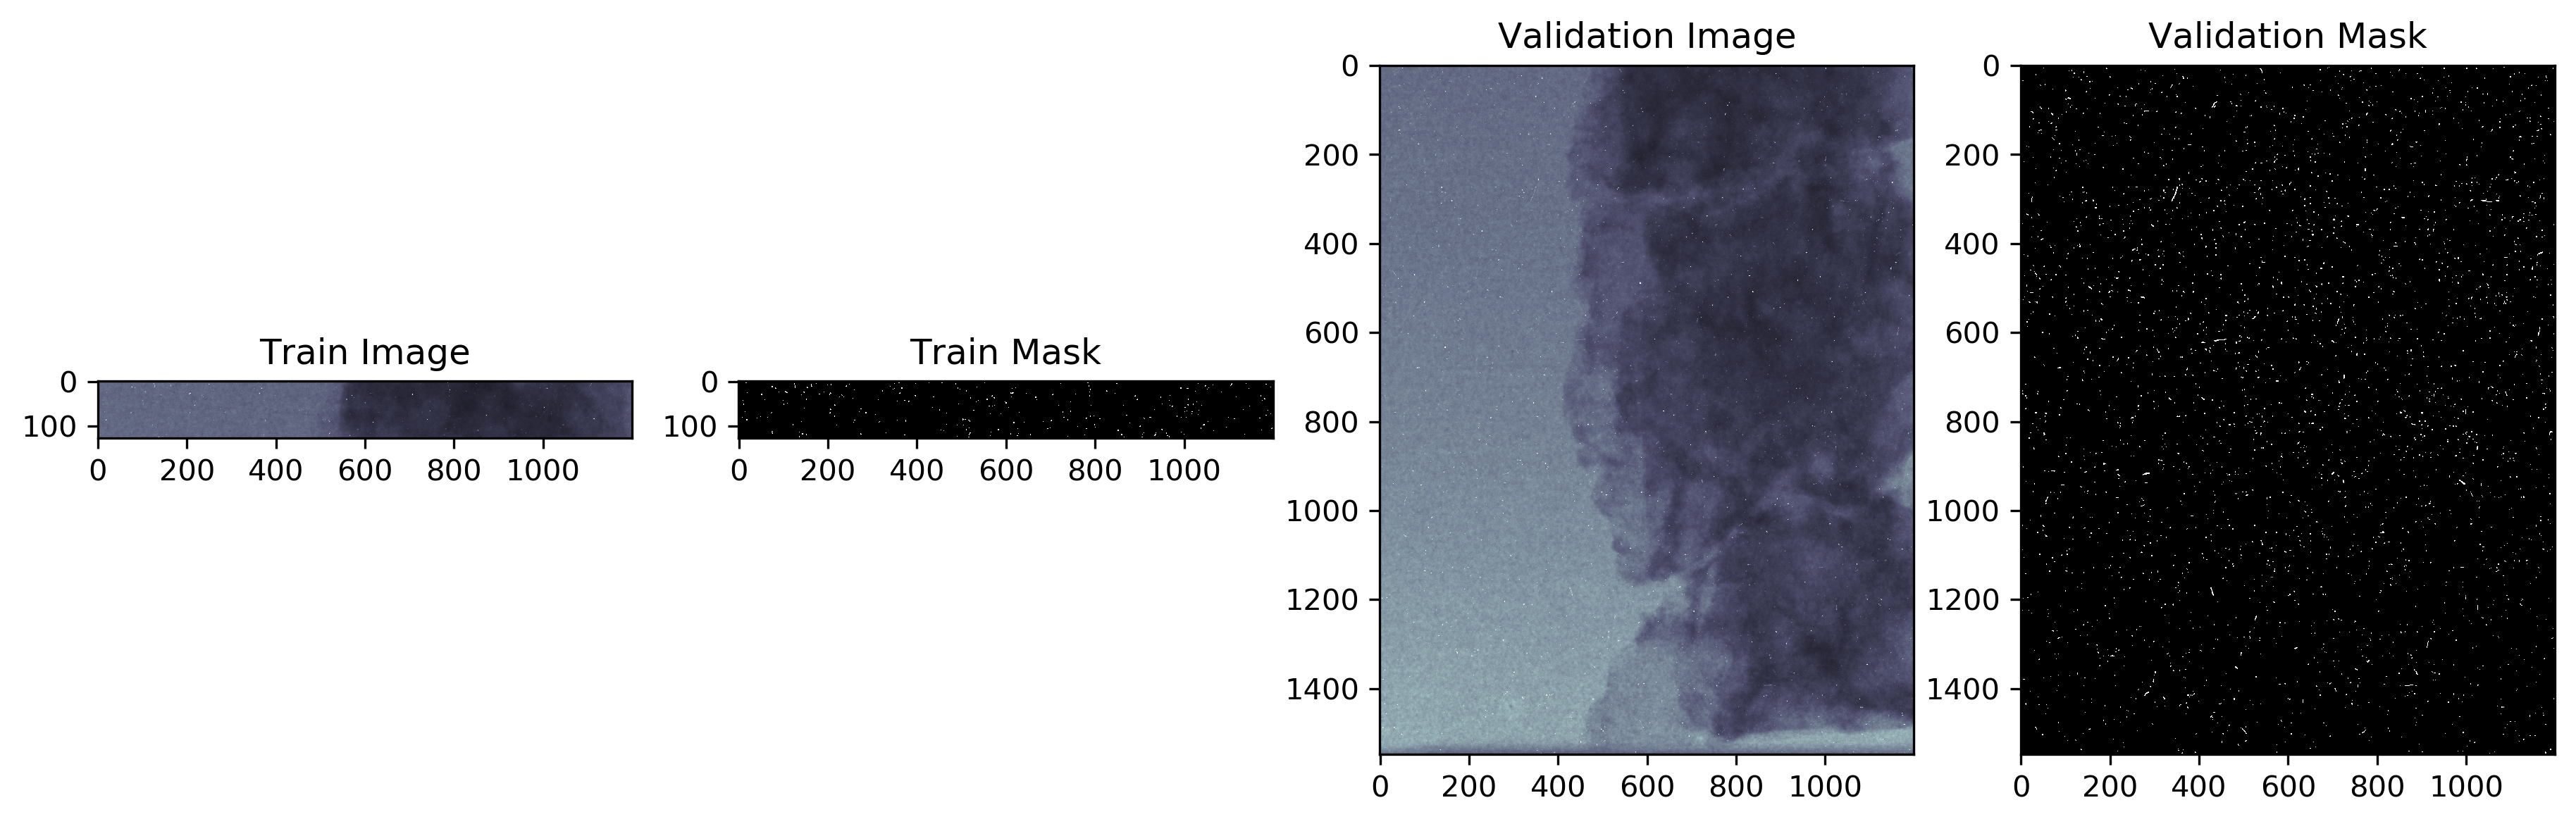

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
%matplotlib inline

train_img, valid_img = forig[128:256, 300:1500], forig[500:, 300:1500]
train_mask, valid_mask = mask[128:256, 300:1500], mask[500:, 300:1500]
# add channels and sample dimensions
def prep_img(x, n=1): 
    return (prep_mask(x, n=n)-train_img.mean())/train_img.std()


def prep_mask(x, n=1): 
    return np.stack([np.expand_dims(x, -1)]*n, 0)


print('Training', train_img.shape, train_mask.shape)
print('Validation Data', valid_img.shape, valid_mask.shape)
fig, ax = plt.subplots(1, 4, figsize=(15, 6), dpi=300); ax=ax.ravel()

ax[0].imshow(train_img, cmap='bone',vmin=0,vmax=4000)
ax[0].set_title('Train Image')
ax[1].imshow(train_mask, cmap='bone')
ax[1].set_title('Train Mask')

ax[2].imshow(valid_img, cmap='bone',vmin=0,vmax=4000)
ax[2].set_title('Validation Image')
ax[3].imshow(valid_mask, cmap='bone')
ax[3].set_title('Validation Mask');

# Results from Untrained Model
- We can make predictions with an untrained model (default parameters)
- but we clearly do not expect them to be very good

Text(0.5, 1.0, 'Ground Truth')

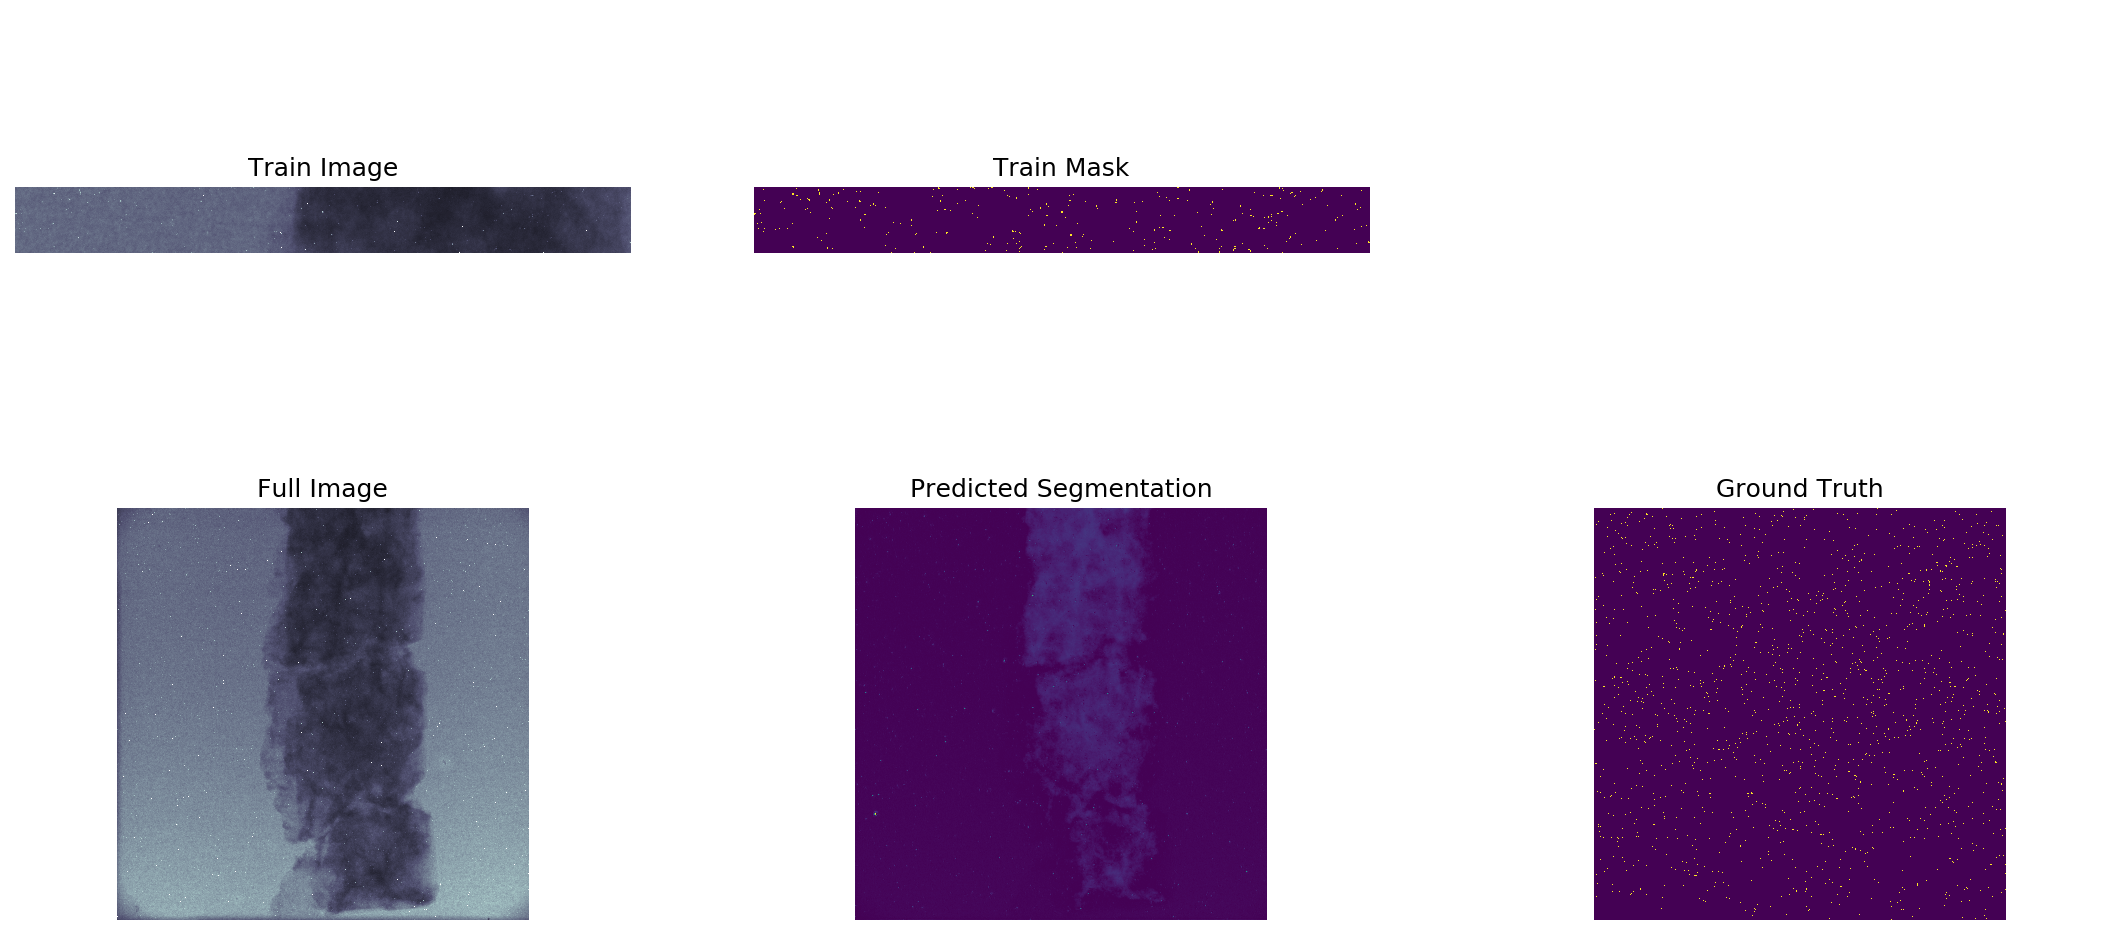

In [212]:
fig, m_axs = plt.subplots(2, 3,
                          figsize=(18, 8), dpi=150)
for c_ax in m_axs.ravel():
    c_ax.axis('off')
((ax1, ax2, _), (ax3, ax4, ax5)) = m_axs
ax1.imshow(train_img, cmap='bone',vmin=0,vmax=4000)
ax1.set_title('Train Image')
ax2.imshow(train_mask, cmap='viridis')
ax2.set_title('Train Mask')

ax3.imshow(forig, cmap='bone',vmin=0, vmax=4000)
ax3.set_title('Full Image')

unet_pred = t_unet.predict(prep_img(forig))[0, :, :, 0]
ax4.imshow(unet_pred,
           cmap='viridis', vmin=0, vmax=1)
ax4.set_title('Predicted Segmentation')

ax5.imshow(mask,
           cmap='viridis')
ax5.set_title('Ground Truth')

# A general note on the following demo
This is a very bad way to train a model;
- the loss function is poorly chosen, 
- the optimizer can be improved the learning rate can be changed, 
- the training and validation data **should not** come from the same sample (and **definitely** not the same measurement). 

The goal is to be aware of these techniques and have a feeling for how they can work for complex problems 

# Training conditions
- [Loss function](https://en.wikipedia.org/wiki/Loss_function) - MAE
- Optimizer - [Stochastic Gradient Decent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)
- 20 Epochs (training iterations)
- Metrics 
    1. Binary accuracy (percentage of pixels correct classified)
$$BA=\frac{1}{N}\sum_i(f_i==g_i)$$
    2. Mean absulute error
    
Another popular metric is the Dice score
$$DSC=\frac{2|X \cap Y|}{|X|+|Y|}=\frac{2\,TP}{2TP+FP+FN}$$

### Let's train the model

In [213]:
import keras.optimizers as opt
import keras.losses as loss
import keras.metrics as metrics
mlist = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.MeanAbsoluteError(name='mae'),
]

t_unet.compile(
    # we use a simple loss metric of mean-squared error to optimize
    loss=loss.BinaryCrossentropy(),
    # we use stochastic gradient descent to optimize
    optimizer=opt.Adam(lr=1e-3),
    # we keep track of the number of pixels correctly classified and the mean absolute error as well
    metrics=mlist
)

loss_history = t_unet.fit(prep_img(train_img, n=5),
                          prep_mask(train_mask, n=5),
                          validation_data=(prep_img(valid_img),
                                           prep_mask(valid_mask)),
                          epochs=20)

Train on 5 samples, validate on 1 samples
Epoch 1/20
5/5 [==============================] - 12s 2s/step - loss: 0.0817 - tp: 0.0000e+00 - fp: 5.0000 - tn: 761680.0000 - fn: 6315.0000 - accuracy: 0.9918 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5814 - mae: 0.0563 - val_loss: 0.1025 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 1839789.0000 - val_fn: 17800.0000 - val_accuracy: 0.9904 - val_precision: 0.8182 - val_recall: 5.0536e-04 - val_auc: 0.6614 - val_mae: 0.0096
Epoch 2/20
5/5 [==============================] - 11s 2s/step - loss: 0.0926 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 761685.0000 - fn: 6315.0000 - accuracy: 0.9918 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6360 - mae: 0.0083 - val_loss: 0.1620 - val_tp: 636.0000 - val_fp: 755.0000 - val_tn: 1839036.0000 - val_fn: 17173.0000 - val_accuracy: 0.9903 - val_precision: 0.4572 - val_recall: 0.0357 - val_auc: 0.6738 - val_mae: 0.1382
Epoch 3/20
5/5 [==============================] - 11s 2s/step - loss: 0.1180 -

Epoch 20/20
5/5 [==============================] - 12s 2s/step - loss: 0.0276 - tp: 460.0000 - fp: 185.0000 - tn: 761500.0000 - fn: 5855.0000 - accuracy: 0.9921 - precision: 0.7132 - recall: 0.0728 - auc: 0.9606 - mae: 0.0089 - val_loss: 0.0284 - val_tp: 1267.0000 - val_fp: 565.0000 - val_tn: 1839226.0000 - val_fn: 16542.0000 - val_accuracy: 0.9907 - val_precision: 0.6916 - val_recall: 0.0711 - val_auc: 0.9775 - val_mae: 0.0115


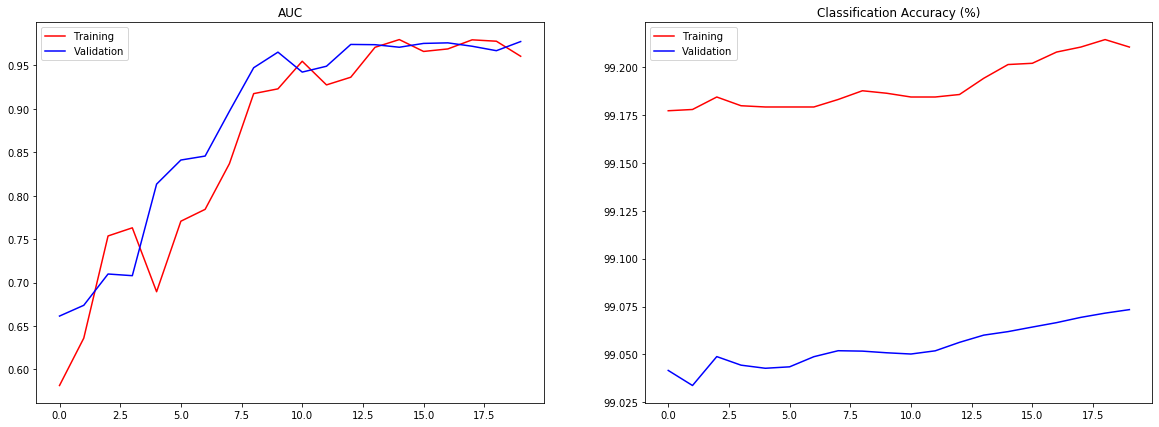

In [214]:
fig, (ax1, ax2) = plt.subplots(1, 2,
                               figsize=(20, 7))
ax1.plot(loss_history.epoch,
         loss_history.history['auc'], 'r-', label='Training')
ax1.plot(loss_history.epoch,
         loss_history.history['val_auc'], 'b-', label='Validation')
ax1.set_title('AUC')
ax1.legend()

ax2.plot(loss_history.epoch,
         100*np.array(loss_history.history['accuracy']), 'r-', label='Training')
ax2.plot(loss_history.epoch,
         100*np.array(loss_history.history['val_accuracy']), 'b-', label='Validation')
ax2.set_title('Classification Accuracy (%)')
ax2.legend()

Text(0.5, 1.0, 'Ground Truth')

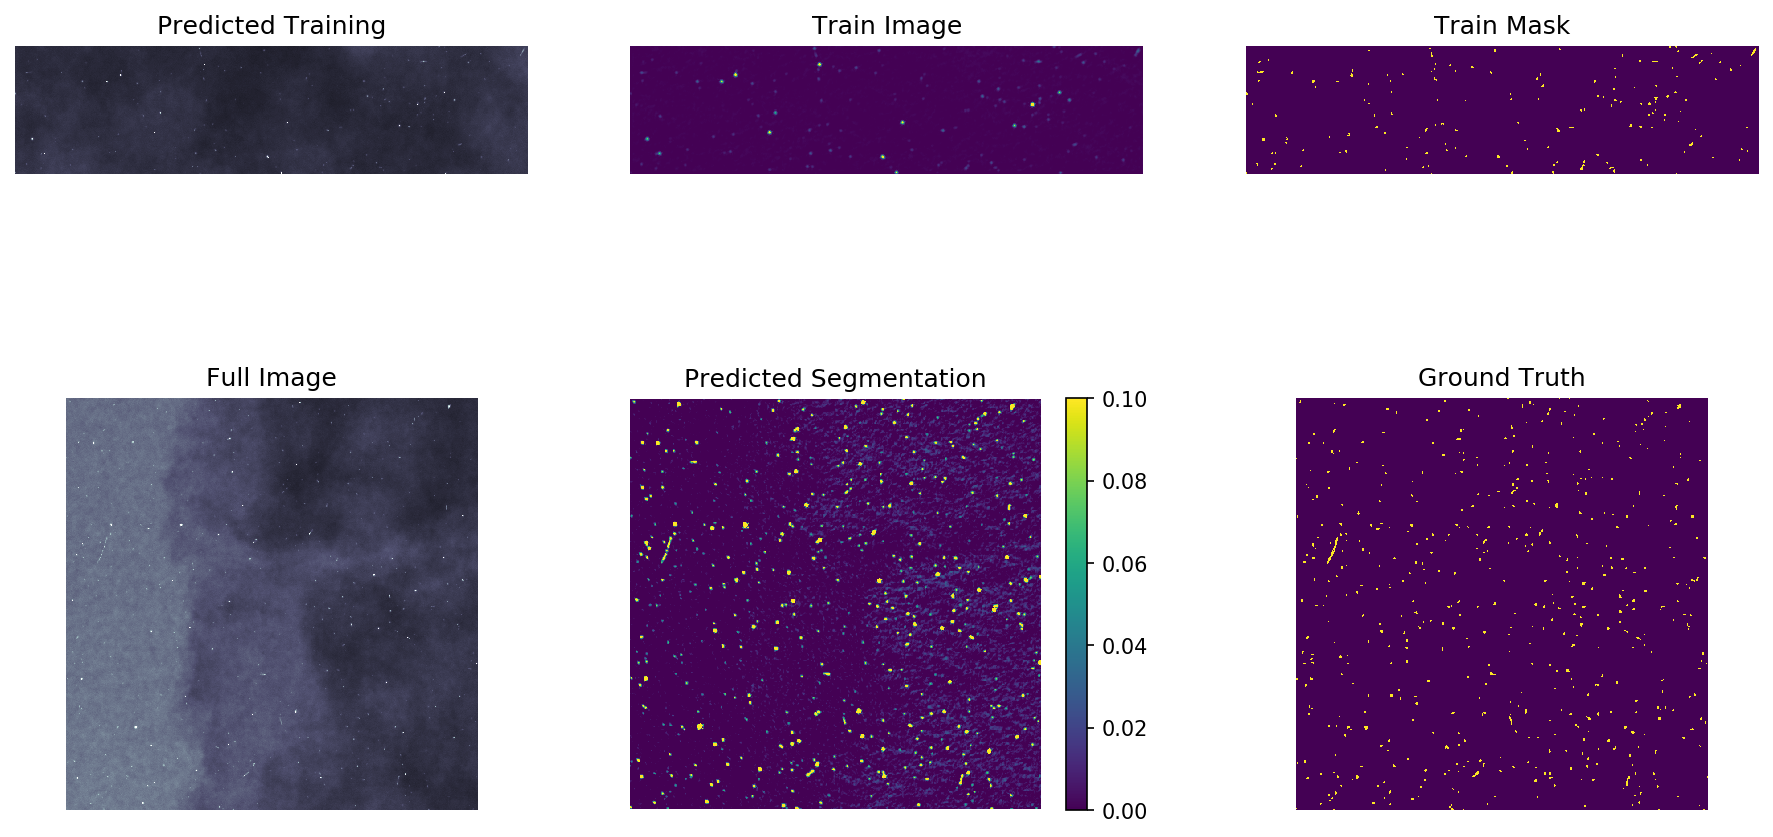

In [215]:
fig, m_axs = plt.subplots(2, 3,
                          figsize=(15, 8), dpi=150)
for c_ax in m_axs.flatten():
    c_ax.axis('off')
((ax1, ax15, ax2), (ax3, ax4, ax5)) = m_axs

wpos = [600,600]
ww   = 512
ax1.imshow(train_img[:,wpos[1]:(wpos[1]+ww)], cmap='bone', vmin=0, vmax=4000)
ax15.set_title('Train Image')
ax15.imshow(t_unet.predict(prep_img(train_img[:,wpos[1]:(wpos[1]+ww)]))[0, :, :, 0],
            cmap='viridis', vmin=0, vmax=1)
ax1.set_title('Predicted Training')
ax2.imshow(train_mask[:,wpos[1]:(wpos[1]+ww)], cmap='viridis')
ax2.set_title('Train Mask')

ax3.imshow(forig[wpos[0]:(wpos[0]+ww),wpos[1]:(wpos[1]+ww)], cmap='bone', vmin=0, vmax=4000)
ax3.set_title('Full Image')
unet_pred = t_unet.predict(prep_img(forig))[0, :, :, 0]
f4=ax4.imshow(unet_pred[wpos[0]:(wpos[0]+ww),wpos[1]:(wpos[1]+ww)],
           cmap='viridis', vmin=0, vmax=0.1)
ax4.set_title('Predicted Segmentation')
fig.colorbar(f4,ax=ax4)

ax5.imshow(mask[wpos[0]:(wpos[0]+ww),wpos[1]:(wpos[1]+ww)],
           cmap='viridis')
ax5.set_title('Ground Truth')

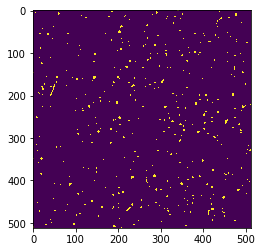

In [216]:
plt.imshow(0.05<unet_pred[wpos[0]:(wpos[0]+ww),wpos[1]:(wpos[1]+ww)])

In [ ]:
def showHitPerformance(gt,pred) :
    tp = 

(<matplotlib.image.AxesImage at 0x1b7e91b9b48>,
 Text(0.5, 1.0, 'True Negative'))

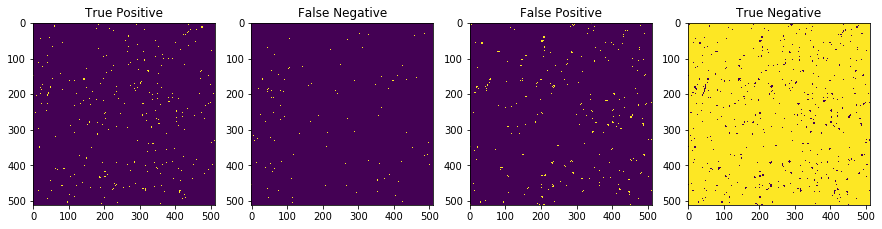

In [220]:
fig,ax = plt.subplots(1,4,figsize=(15,5))
gt = mask[wpos[0]:(wpos[0]+ww),wpos[1]:(wpos[1]+ww)]
pr = 0.05<unet_pred[wpos[0]:(wpos[0]+ww),wpos[1]:(wpos[1]+ww)]
ax[0].imshow(gt*pr), ax[0].set_title('True Positive')
ax[1].imshow(gt*(1-pr)), ax[1].set_title('False Negative')
ax[2].imshow((1-gt)*pr), ax[2].set_title('False Positive')
ax[3].imshow((1-gt)*(1-pr)), ax[3].set_title('True Negative')

In [263]:
import matplotlib.colors as colors
from sklearn.metrics import confusion_matrix
import seaborn as sn

def showHitMap(gt,pr,ax=None) :
    if ax is None :
        fig, ax = plt.subplots(1,2,figsize=(12,4))
        
    m=4*gt*pr+ 2*gt*(1-pr) + 3*(1-gt)*pr + (1-gt)*(1-pr)
    clst = np.array([[64,64,64],
                     [51, 204, 255],
                     [255, 0, 102],
                     [255, 255,255]])/255.0
    cmap = colors.ListedColormap(clst)
    mi=ax[1].imshow(m, cmap=cmap)
    cb=plt.colorbar(mi,ticks=[1.35, 2.1, 2.85,3.6]); cb.ax.set_yticklabels(['True Negative', 'False Negative', 'False Positive', 'True Positive']);
    ax[1].set_title('Hit map')
    
    cmat = confusion_matrix(gt.ravel(), pr.ravel(), normalize='all')
    sn.heatmap(cmat, annot=True,ax=ax[0]); ax[0].set_title('Confusion matrix');
    ax[0].set_xticklabels(['Negative','Positive']);
    ax[0].set_yticklabels(['Negative','Positive']);
    ax[0].set_ylabel('Ground Truth')
    ax[0].set_xlabel('Prediction');


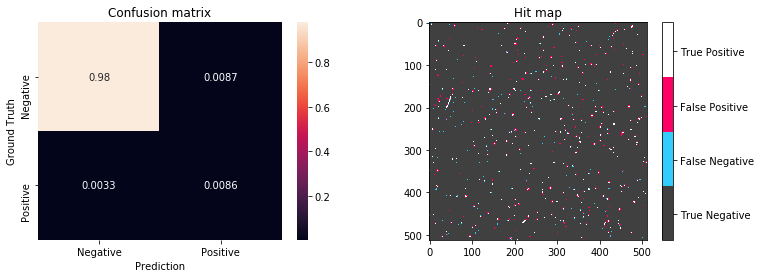

In [264]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

showHitMap(gt,pr,ax=ax)